In [27]:
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont


def draw_bboxes(
    image_np: np.ndarray,
    bboxes_np: np.ndarray,
    labels_np: np.ndarray,
    color: tuple = (255, 0, 0),
    font_size: int = 16,
    thickness: int = 2,
) -> Image.Image:
    """
    在图像上绘制边界框和标签（支持中文）

    Args:
        image_np (np.ndarray): shape (H, W, 3), dtype uint8
        bboxes_np (np.ndarray): shape (N, 4), xyxy格式, dtype int32
        labels_np (np.ndarray or list): 长度为N的字符串数组或列表
        color (tuple): 边界框和文字颜色，默认红色 (R, G, B)
        font_size (int): 标签字体大小
        thickness (int): 边界框线宽

    Returns:
        Image.Image: 绘制完成的PIL图像
    """
    # 转换为PIL图像
    img = Image.fromarray(image_np)
    draw = ImageDraw.Draw(img)

    # 加载字体（支持中文）
    font_path = "/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc"
    try:
        font = ImageFont.truetype(font_path, font_size)
    except Exception as e:
        print(f"[Warning] Failed to load font {font_path}: {e}, using default font.")
        font = ImageFont.load_default()

    # 转换边界框为 (x1, y1, x2, y2) 格式
    for i, box in enumerate(bboxes_np):
        label = str(labels_np[i])

        x1, y1, x2, y2 = map(int, box)

        # 绘制矩形框
        draw.rectangle([x1, y1, x2, y2], outline=color, width=thickness)

        # 计算文本尺寸
        text_bbox = draw.textbbox((0, 0), label, font=font)
        text_w = text_bbox[2] - text_bbox[0]
        text_h = text_bbox[3] - text_bbox[1]

        # 文本背景区域
        text_bg_rect = [x1, y1 - text_h - 5, x1 + text_w, y1]
        draw.rectangle(text_bg_rect, fill=color)

        # 绘制文本
        draw.text((x1, y1 - text_h - 5), label, fill=(255, 255, 255), font=font)

    return img

def visualize_bbox_datasets(ds, samples=5):
    """Visualizes original image and augmented versions."""
    # Prepare visualization pipeline (strip Normalize, ToTensor)
    figure, ax = plt.subplots(1, samples, figsize=(15, 5))

    # Draw original
    select_idx = np.random.randint(0, len(ds))

    # Draw augmented samples
    for i in range(samples):
        # Apply the visualization transform
        # Ensure labels are passed correctly based on label_fields
        meta = ds[select_idx]
        aug_image = meta['image'].numpy().astype(np.uint8)
        aug_bboxes = meta['bboxes'].numpy()
        aug_labels = meta['labels'].numpy()
        augmented_drawn = draw_bboxes(aug_image, aug_bboxes, aug_labels)
        ax[i].imshow(augmented_drawn)
        ax[i].set_title(f"Augmented {i+1}")
        ax[i].axis("off")

    plt.tight_layout()
    plt.show()

In [4]:
from hydra import compose, initialize
from omegaconf import DictConfig

# ---------------------------------------------------------------------#
#       读取配置文件
# ---------------------------------------------------------------------#
with initialize(version_base=None, config_path="conf"):
    cfg: DictConfig = compose(config_name="config", overrides=["md@_global_=frcnn_dinov3", "ds@data=nodule"])
    print(cfg)

{'seed': 172, 'csdp': None, 'sdp': None, 'model': {'weight_decay': 0.0001, 'lr': 0.0001, 'lr_backbone': 3e-05, 'lr_scheduler': 'step', 'lr_step_size': 1, 'lr_gamma': 0.975, 'compile': False, 'optimizer': 'adam', 'muon_lr': 0.001, 'muon_weight_decay': 0.003, 'input_size_hw': '${data.input_size_hw}', 'num_classes': '${data.num_classes}', '_target_': 'litdetect.model.faster_rcnn.ModuleWrapper', 'model_name': 'frcnn_convnext_small_dinov3', 'backbone_name': 'convnext_small', 'backbone_type': 'dinov3', 'weights_path': '/data/16t/wxh/ds/ckpts/dinov3_convnext_small_pretrain_lvd1689m-296db49d.pth', 'REPO_DIR': '/data/16t/wxh/dinov3', 'pretrained': True, 'iou_thres': 0.45, 'conf_thres': 0.05}, 'data': {'dataset': 'litdetect.data.litdetect.LitDetectDataset', 'input_size_hw': [512, 512], 'train_batch_size': 14, 'val_batch_size': 5, 'num_workers': 16, 'augmentation_train': {'_target_': 'albumentations.Compose', 'transforms': [{'_target_': 'albumentations.LongestMaxSize', 'max_size_hw': '${data.inpu

In [12]:
from litdetect.data import DataInterface
# ---------------------------------------------------------------------#
#       实例化数据集
# ---------------------------------------------------------------------#
dl = DataInterface(**cfg.data)
dl.setup('fit')

[2026-01-19 22:02:52,610][/data/16t/wxh/LitDetect/litdetect/data/data_interface.py][INFO] - stage is fit, set dataset
[2026-01-19 22:02:52,631][/data/16t/wxh/LitDetect/litdetect/data/data_interface.py][INFO] - collate_fn was successfully loaded.
[2026-01-19 22:02:54,561][/data/16t/wxh/LitDetect/litdetect/data/data_interface.py][INFO] - collate_fn was successfully loaded.


In [13]:
dl.trainset.transforms

Compose([
  LongestMaxSize(p=1.0, area_for_downscale='image', interpolation=1, mask_interpolation=0, max_size=None, max_size_hw=(512, 512)),
  PadIfNeeded(p=1.0, border_mode=0, fill=0.0, fill_mask=0.0, min_height=512, min_width=512, pad_height_divisor=None, pad_width_divisor=None, padding=0, position='center'),
  SquareSymmetry(p=0.5),
  Affine(p=0.3, balanced_scale=True, border_mode=0, fill=0.0, fill_mask=0.0, fit_output=False, interpolation=1, keep_ratio=False, mask_interpolation=0, rotate=(-30.0, 30.0), rotate_method='largest_box', scale={'x': (0.8, 1.2), 'y': (0.8, 1.2)}, shear={'x': (0.0, 0.0), 'y': (0.0, 0.0)}, translate_percent=None, translate_px={'x': (0, 0), 'y': (0, 0)}),
  Sequential([
    SmallestMaxSize(p=1.0, area_for_downscale=None, interpolation=1, mask_interpolation=0, max_size=640, max_size_hw=None),
    RandomCrop(p=1.0, border_mode=0, fill=0.0, fill_mask=0.0, height=512, pad_if_needed=False, pad_position='center', width=512),
  ], p=0.1),
  Normalize(p=1.0, max_pixe

In [14]:
# ---------------------------------------------------------------------#
#       删除ToTensor和Normalize
# ---------------------------------------------------------------------#
dl.trainset.transforms = dl.trainset.transforms - A.Normalize - A.ToTensorV2
dl.valset.transforms = dl.valset.transforms - A.Normalize - A.ToTensorV2

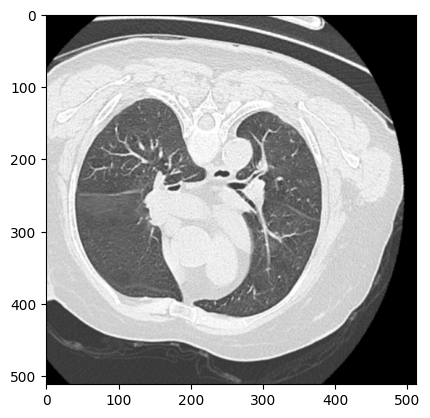

In [23]:
# ---------------------------------------------------------------------#
#       获取数据并绘制
# ---------------------------------------------------------------------#
c = dl.trainset[18]
plt.imshow(c['image'].numpy().astype(np.uint8))
plt.show()

In [ ]:
c

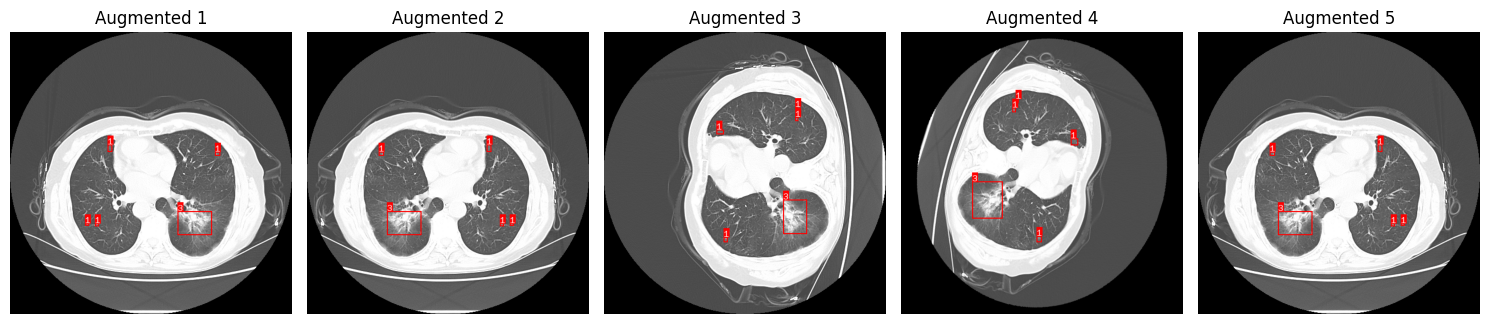

In [28]:
visualize_bbox_datasets(dl.trainset, samples=5)